In [10]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
import pathlib
import os
from PIL import Image
import glob
import tensorflow as tf
import tensorflow
from tensorflow import keras

In [11]:
data = glob.glob('./dataset/*/*.jpeg')

In [12]:
len(data)

5856

In [13]:
data[0].split('\\')[1]

'normal'

In [14]:
from tqdm import tqdm
features = []
labels = []
for i in tqdm(range(len(data))):
    image = cv2.imread(data[i])
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 2.5)
    final_img = clahe.apply(image)
    final_img = cv2.cvtColor(final_img,cv2.COLOR_GRAY2RGB)
    final_imag = cv2.merge([final_img, final_img, final_img])
    features.append(final_img)
    cls = data[i].split('\\')[1]
    if cls=='pneumonia':
        lbl = 1
    else:
        lbl = 0
    labels.append(lbl)

100%|██████████████████████████████████████████████████████████████████████████████| 5856/5856 [01:13<00:00, 80.00it/s]


In [16]:
features = np.array(features)
labels = np.array(labels)

In [17]:
print(features.shape,labels.shape)

(5856, 224, 224, 3) (5856,)


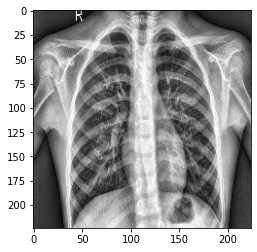

In [18]:
import matplotlib.pyplot as plt
plt.imshow(features[0])

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.1,random_state=1)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=1)

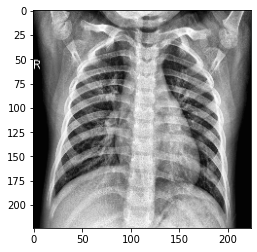

In [21]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [22]:
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(4743, 224, 224, 3) (586, 224, 224, 3) (527, 224, 224, 3)
(4743,) (586,) (527,)


In [23]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=33, zoom_range=0.2, width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)

In [24]:
datagen.fit(x_train)

In [25]:
y_train=tf.keras.utils.to_categorical(y_train,2)
y_test=tf.keras.utils.to_categorical(y_test,2)
y_val=tf.keras.utils.to_categorical(y_val,2)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import softmax, relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
model = Sequential()
base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.add(base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=2e-5),metrics=['accuracy'])

In [29]:
history=model.fit(datagen.flow(x_train,y_train,batch_size=32), validation_data=(x_val,y_val), epochs=50)

Epoch 1/50
149/149 [==============================] - 53s 294ms/step - loss: 0.9719 - accuracy: 0.7729 - val_loss: 0.4595 - val_accuracy: 0.8292
Epoch 2/50
149/149 [==============================] - 39s 263ms/step - loss: 0.2162 - accuracy: 0.9236 - val_loss: 0.3234 - val_accuracy: 0.8710
Epoch 3/50
149/149 [==============================] - 40s 265ms/step - loss: 0.1831 - accuracy: 0.9342 - val_loss: 0.3658 - val_accuracy: 0.8577
Epoch 4/50
149/149 [==============================] - 40s 269ms/step - loss: 0.1631 - accuracy: 0.9399 - val_loss: 0.1001 - val_accuracy: 0.9602
Epoch 5/50
149/149 [==============================] - 40s 270ms/step - loss: 0.1598 - accuracy: 0.9384 - val_loss: 0.4309 - val_accuracy: 0.8387
Epoch 6/50
149/149 [==============================] - 40s 270ms/step - loss: 0.1150 - accuracy: 0.9557 - val_loss: 0.1669 - val_accuracy: 0.9317
Epoch 7/50
149/149 [==============================] - 40s 270ms/step - loss: 0.1330 - accuracy: 0.9528 - val_loss: 0.1526 - val_ac

In [30]:
model.save('./proposed_model.h5')

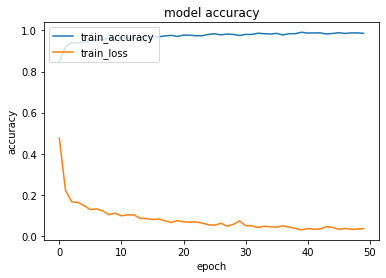

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'train_loss'], loc='upper left')
plt.show()

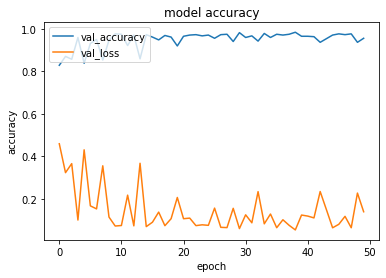

In [32]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'val_loss'], loc='upper left')
plt.show()

In [33]:
y_pred=model.predict(x_test)

In [34]:
#converting labels from probability to assurity
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

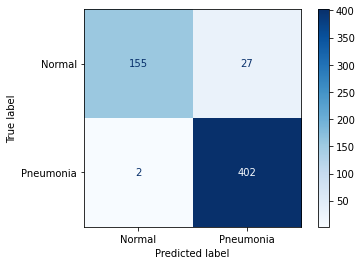

In [35]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
labels=['Normal', 'Pneumonia']
cm = confusion_matrix(y_pred,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [36]:
target_names = ['Normal','Pneumonia']
print(classification_report(y_pred,y_test, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.85      0.91       182
   Pneumonia       0.94      1.00      0.97       404

    accuracy                           0.95       586
   macro avg       0.96      0.92      0.94       586
weighted avg       0.95      0.95      0.95       586



In [37]:
from tensorflow.keras.models import load_model
model = load_model('./proposed_model.h5')

In [38]:
classes=['Normal','Pneumonia']
def plot_results(x,y,z,index):
    plt.imshow(x[index])
    plt.xlabel(classes[y[index]])
    plt.ylabel(classes[z[index]])

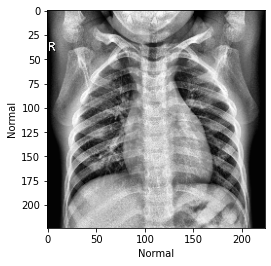

In [39]:
plot_results(x_test,y_pred,y_test,39)

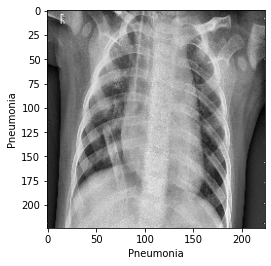

In [40]:
plot_results(x_test,y_pred,y_test,49)

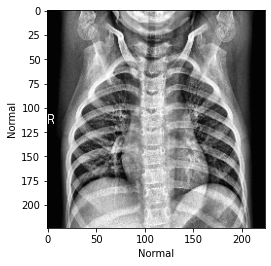

In [41]:
plot_results(x_test,y_pred,y_test,59)

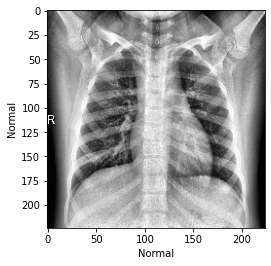

In [42]:
plot_results(x_test,y_pred,y_test,69)